# Importing required packages

In [36]:
import os, tensorflow as tf, keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, MaxPooling2D, Input, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.initializers import he_normal

# Loading Datasets

In [37]:
from PIL import Image
import pandas as pd
import glob

# load the dataset => training and test sets

train_dir = os.path.join("/kaggle/input/openaimer-2025-track1-dataset/OpenAImer2025_Image_Classification/OpenAImer/train")
test_dir = os.path.join("/kaggle/input/openaimer-2025-track1-dataset/OpenAImer2025_Image_Classification/OpenAImer/test")

test_image_paths = glob.glob(test_dir + "/*.jpg")

test_df = pd.DataFrame({
    'filename': test_image_paths,
    'class': ['unknown'] * len(test_image_paths)
})

# img = Image.open("/kaggle/input/openaimer-2025-track1-dataset/OpenAImer2025_Image_Classification/OpenAImer/test/YehKarkeDikhaao100429.jpg")
# width, height = img.size
# print(f"Image resolution: {width}x{height}")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
input_shape = (224, 224, 3)
projection_units = 128
num_classes = 7
batch_size = 32
encoder_trainable = True
dropout_rate1 = 0.4
dropout_rate2 = 0.1

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset = 'training'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False,
)

Found 3043 images belonging to 7 classes.
Found 1401 validated image filenames belonging to 1 classes.


# create encoder with projection head

In [38]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os

# Step 1: Create the base encoder model using Resnet50 architecture
def create_encoder(trainable=True):
    base_model = keras.applications.ResNet50(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape,
        pooling="avg"
    )
    base_model.trainable = trainable
    
    inputs = keras.Input(shape=input_shape)
    x = base_model(inputs)
    outputs = layers.Dense(512, activation=None)(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name="encoder")
    return model

# Step 2: Add projection head for contrastive learning
def add_projection_head(encoder):
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    outputs = layers.Dense(projection_units, activation="relu")(features)
    model = keras.Model(
        inputs=inputs, outputs=outputs, name="encoder_with_projection_head"
    )
    return model

# create classifier

In [39]:
def create_classifier(encoder, trainable=False):
    for layer in encoder.layers:
        layer.trainable = False
    
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    features = Dropout(dropout_rate1)(features)
    features = Dense(32, activation='relu')(features)
    features = Dropout(dropout_rate2)(features)
    outputs = Dense(num_classes, activation="softmax")(features)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name="classifier")
    return model

# supervised contrastive loss

In [40]:
class SupervisedContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=0.07, name=None):
        super().__init__(name=name)
        self.temperature = temperature

    def call(self, labels, feature_vectors):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        
        # Compute logits (similarity matrix)
        logits = tf.divide(
            tf.matmul(feature_vectors_normalized, tf.transpose(feature_vectors_normalized)),
            self.temperature
        )

        # Mask to remove self-comparisons
        logits_mask = tf.linalg.diag(tf.zeros(tf.shape(logits)[0])) + tf.ones_like(logits) - tf.eye(tf.shape(logits)[0])

        # Labels mask to find positives (same class)
        labels = tf.reshape(labels, [-1, 1])
        matches = tf.equal(labels, tf.transpose(labels))
        matches = tf.cast(matches, tf.float32)
        
        # Remove self-contrast
        matches *= logits_mask

        # Compute log-softmax over rows
        exp_logits = tf.exp(logits) * logits_mask
        log_prob = logits - tf.math.log(tf.reduce_sum(exp_logits, axis=1, keepdims=True) + 1e-9)

        # Loss for each anchor: average log_prob of positives
        mean_log_prob_pos = tf.reduce_sum(matches * log_prob, axis=1) / (tf.reduce_sum(matches, axis=1) + 1e-9)

        # Final loss
        loss = -tf.reduce_mean(mean_log_prob_pos)
        return loss

# Pretraining encoder

In [41]:
def train_encoder(train_generator, epochs=10):
    # Create the encoder and projection head
    encoder = create_encoder(trainable=True)
    encoder_with_projection = add_projection_head(encoder)
    
    # Define the loss function
    supcon_loss = SupervisedContrastiveLoss(temperature=0.1)
    
    # Compile the model
    encoder_with_projection.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss=supcon_loss,
    )

    # learning rate scheduler
    lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, verbose=1, min_lr=1e-8)
    
    # checkpoints
    checkpoint = [
        ModelCheckpoint(
            "/kaggle/working/encoder_with_projection.weights.h5",
            monitor="loss", 
            save_best_only=True, 
            save_weights_only=True, 
            mode="min",
            verbose=1
        )
    ]
    
    # Train the encoder
    history = encoder_with_projection.fit(
        train_generator,
        epochs=epochs,
        callbacks=[lr_scheduler, checkpoint]
    )
    
    # Load the best weights
    encoder_with_projection.load_weights("/kaggle/working/encoder_with_projection.weights.h5")
    
    # Remove the projection head to get the trained encoder
    trained_encoder = encoder
    return trained_encoder, history

# train classifier

In [42]:
def train_classifier(encoder, train_generator, val_generator=None, epochs=10):
    # Create the classifier with the frozen encoder
    classifier = create_classifier(encoder, trainable=False)
    
    # Compile the classifier
    classifier.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss='SparseCategoricalCrossentropy',
        metrics=["accuracy"]
    )

    # learning rate scheduler
    lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, verbose=1, min_lr=1e-8)
    
    # Prepare checkpoint
    checkpoint = [
        ModelCheckpoint(
            "/kaggle/working/track1_classifier.weights.h5", 
            monitor="loss", 
            save_best_only=True, 
            save_weights_only=True, 
            mode="min", 
            verbose=1
        )
    ]
    
    # Train the classifier
    history = classifier.fit(
        train_generator,
        epochs=epochs,
        callbacks=[lr_scheduler, checkpoint]
    )
    
    # Load the best weights
    classifier.load_weights("/kaggle/working/track1_classifier.weights.h5")
    return classifier, history

# model fitting

In [43]:
print("Class mapping:", train_generator.class_indices)
num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")
    
# Train the encoder with contrastive learning
print("\n=== Training Encoder with Contrastive Learning ===")
trained_encoder, encoder_history = train_encoder(
    train_generator=train_generator,
    epochs=60
)

# Train the classifier using the trained encoder
print("\n=== Training Classifier with Frozen Encoder ===")
classifier, classifier_history = train_classifier(
    encoder=trained_encoder,
    train_generator=train_generator,
    epochs=60
)

Class mapping: {'bus': 0, 'car': 1, 'cat': 2, 'cricket': 3, 'dog': 4, 'football': 5, 'product': 6}
Number of classes: 7

=== Training Encoder with Contrastive Learning ===
Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - loss: 2.1047
Epoch 1: loss improved from inf to 1.92122, saving model to /kaggle/working/encoder_with_projection.weights.h5
96/96 ━━━━━━━━━━━━━━━━━━━━ 97s 348ms/step - loss: 2.1028 - learning_rate: 1.0000e-04
Epoch 2/60
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 1.6892
Epoch 2: loss improved from 1.92122 to 1.69271, saving model to /kaggle/working/encoder_with_projection.weights.h5
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 167ms/step - loss: 1.6892 - learning_rate: 1.0000e-04
Epoch 3/60
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 1.6748
Epoch 3: loss improved from 1.69271 to 1.68155, saving model to /kaggle/working/encoder_with_projection.weights.h5
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 168ms/step - loss: 1.6749 - learning_rate: 1.0000e-04
Epoch 4/60
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 1.6404
Epoch 4: loss improved from 1.68155 to 1.64246, saving model to /kaggle/working/encoder_with_projection.weights.h5
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 1

# plotting accuracy and loss

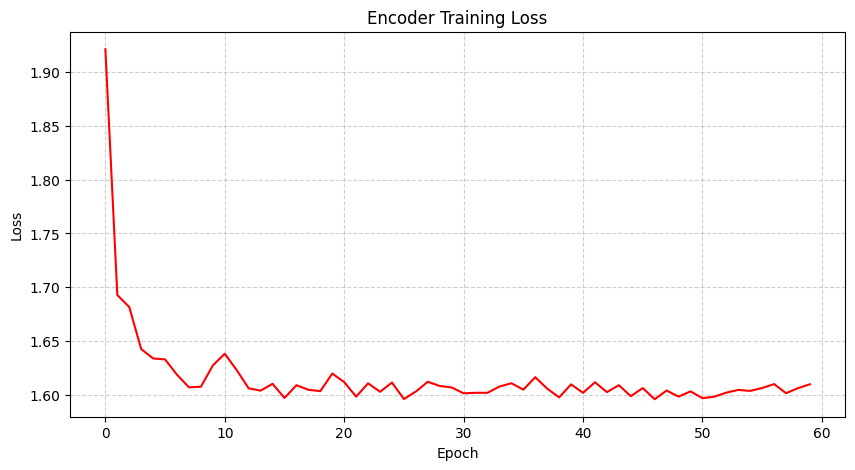

Final encoder training loss: 1.6097


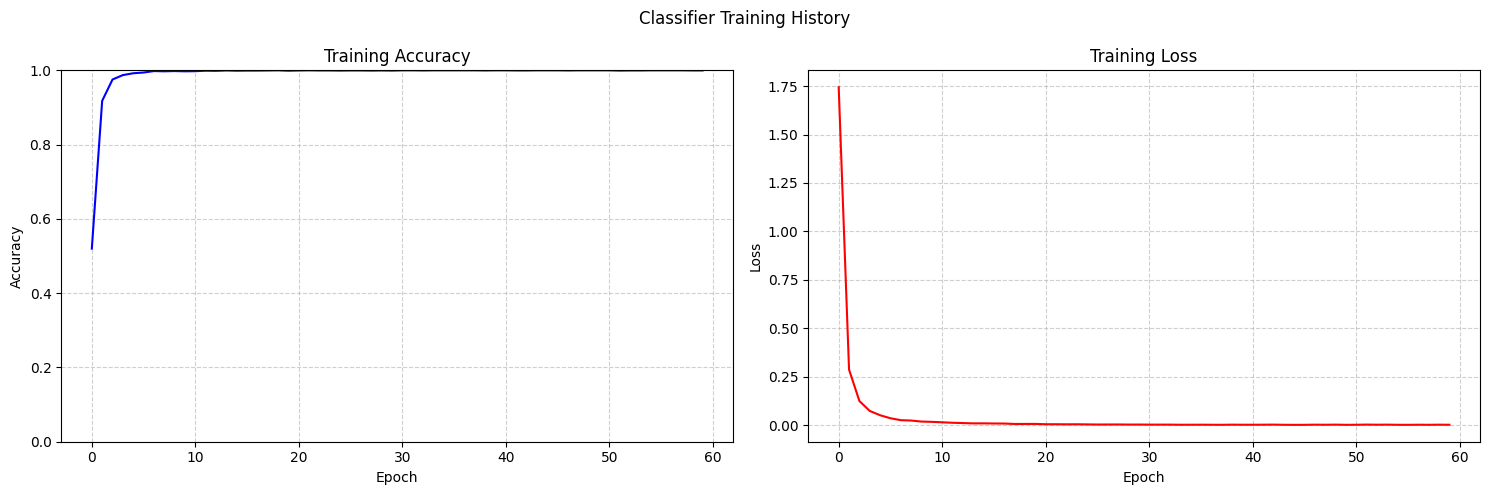

Final training accuracy: 0.9997
Final training loss: 0.0014


In [44]:
import matplotlib.pyplot as plt

def plot_training_history(history, model_type="classifier", title="Training History"):
    
    if model_type.lower() == "classifier":
        # For classifier, plot both accuracy and loss
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot training accuracy
        ax1.plot(history.history['accuracy'], 'b-')
        ax1.set_title('Training Accuracy')
        ax1.set_ylabel('Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylim([0, 1.0])
        ax1.grid(True, linestyle='--', alpha=0.6)
        
        # Plot training loss
        ax2.plot(history.history['loss'], 'r-')
        ax2.set_title('Training Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.grid(True, linestyle='--', alpha=0.6)
        
        plt.suptitle(title)
        plt.tight_layout()
        plt.show()
        
        # Print final metrics
        print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
        print(f"Final training loss: {history.history['loss'][-1]:.4f}")
        
    elif model_type.lower() == "encoder":
        # For encoder, plot only loss since there's no accuracy with contrastive learning
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['loss'], 'r-')
        plt.title('Encoder Training Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()
        
        # Print final metrics
        print(f"Final encoder training loss: {history.history['loss'][-1]:.4f}")


# For encoder
plot_training_history(encoder_history, model_type="encoder", title="Encoder Training History")

# For classifier
plot_training_history(classifier_history, model_type="classifier", title="Classifier Training History")

# Predictions

In [45]:
import numpy as np
import re
import os
import pandas as pd
from collections import OrderedDict

preds = classifier.predict(test_generator, verbose=1)
pred_classes_encoded = np.argmax(preds, axis=1)

image_ids = [
    re.findall(r'\d+', os.path.basename(name))[0]
    for name in test_generator.filenames
]

class_mapping = dict(train_generator.class_indices)
pred_classes = [
    list(class_mapping.keys())[list(class_mapping.values()).index(i)]
    for i in pred_classes_encoded
]

predictions = {
    image_ids[i]: pred_classes[i]
    for i in range(len(pred_classes))
}

predictions = dict(OrderedDict(sorted(predictions.items(), key=lambda x: int(x[0]))))

print(predictions)

44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 200ms/step
{'60072': 'football', '60078': 'cat', '60102': 'football', '60103': 'cat', '60109': 'cat', '60174': 'football', '60217': 'cat', '60258': 'dog', '60282': 'cat', '60296': 'cat', '60308': 'cat', '60327': 'cat', '60329': 'cat', '60335': 'cat', '60361': 'dog', '60372': 'cat', '60399': 'cat', '60405': 'cat', '60406': 'cat', '60459': 'cat', '60478': 'football', '60529': 'cat', '60536': 'football', '60568': 'cat', '60586': 'cat', '60588': 'football', '60635': 'football', '60645': 'cat', '60680': 'football', '60696': 'cat', '60707': 'cat', '60792': 'cat', '60807': 'cat', '60822': 'cat', '60824': 'cat', '60849': 'football', '60853': 'cat', '60876': 'cat', '60908': 'football', '60958': 'cat', '60966': 'cat', '60976': 'cat', '61002': 'cat', '61004': 'cat', '61031': 'football', '61048': 'cat', '61147': 'cat', '61209': 'cat', '61220': 'cat', '61242': 'football', '61257': 'cat', '61258': 'cat', '61275': 'cat', '61319': 'cat', '61329': 'football', '61383': 'fo

# Saving predictions in CSV 

In [75]:
import csv

output_path = "/kaggle/working/track1.csv"

# Write the predictions to a CSV file
with open(output_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["image_id", "label"]) 
    for image_id, label in predictions.items():
        writer.writerow([image_id, label])

print(f"Predictions saved to {output_path}")

Predictions saved to /kaggle/working/track1.csv
